# Atmospheric Rivers: run detection pipeline and QC outputs

This notebook will import the master processing function from the `ar_detection.py` module and run the entire processing workflow with minimal input. Before executing this notebook be sure you've set your `AR_DATA_DIR` environment variable, and have executed both the `download.py` and `compute_ivt.py` scripts.

In [1]:
from ar_detection import detect_all_ars
from config import ard_fp, shp_fp, csv_fp, ak_shp, landfall_6hr_fp, landfall_events_fp

In [2]:
detect_all_ars(ard_fp, 5, shp_fp, csv_fp, ak_shp, landfall_6hr_fp, landfall_events_fp)

Getting axis length (km) for each AR target:: 100%|██████████| 43832/43832 [08:38<00:00, 84.55it/s] 
Getting overall orientation (azimuth) for each AR target:: 100%|██████████| 43832/43832 [09:15<00:00, 78.88it/s] 
Getting mean poleward strength for each AR target:: 100%|██████████| 43832/43832 [00:49<00:00, 876.83it/s] 
Getting directional coherence for each AR target:: 100%|██████████| 43832/43832 [02:31<00:00, 288.58it/s]
Getting total IVT strength for each AR target:: 100%|██████████| 43832/43832 [00:19<00:00, 2219.58it/s]
Getting relative IVT strength for each AR target:: 100%|██████████| 43832/43832 [00:19<00:00, 2204.13it/s]
100%|██████████| 17390/17390 [06:55<00:00, 41.86it/s] 


In [56]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import shapely

In [5]:
#import shps to gdfs
raw = gpd.read_file(landfall_6hr_fp)
events = gpd.read_file(landfall_events_fp)

#import ak shp
ak = gpd.read_file(ak_shp)
# reproject AK coastline to match AR CRS, and dissolve into one multipolygon
ak_ = ak.to_crs(raw.crs)
ak_d = ak_.dissolve()

In [6]:
#count number of landfalling ARs at individual 6hr timesteps
len(raw)

8293

In [7]:
#check AR attributes:
#all properties and criteria are preserved
#AR IDs (index) are unique integers, could also be labeled using year / month / etc

raw.head()

,index,time,label,ratio,length,orient,poleward,dir_coher,mean_dir,tot_str,rel_str,crit1,crit2,crit3,crit4,crit5,crit_cnt,geometry
0,3,1992-01-01 06:00:00,2.0,3.5,4854,37,221,87,358,2230418,488,1,1,1,1,1,5,"POLYGON ((-149.62500 61.12500, -149.37500 61.1..."
1,4,1992-01-01 12:00:00,4.0,4.2,3773,38,224,85,0,2233790,443,1,1,1,1,1,5,"POLYGON ((-143.12500 60.62500, -142.62500 60.6..."
2,21,1992-01-08 00:00:00,2.0,3.8,5254,24,232,81,360,3547765,569,1,1,1,1,1,5,"POLYGON ((-145.62500 60.62500, -145.12500 60.6..."
3,22,1992-01-08 06:00:00,2.0,3.7,4862,27,229,83,1,3182008,575,1,1,1,1,1,5,"POLYGON ((-135.87500 58.62500, -134.62500 58.6..."
4,24,1992-01-08 18:00:00,1.0,2.3,4606,12,249,77,1,3141921,530,1,1,1,1,1,5,"POLYGON ((-146.37500 60.62500, -142.37500 60.6..."


(25.0, 72.0)

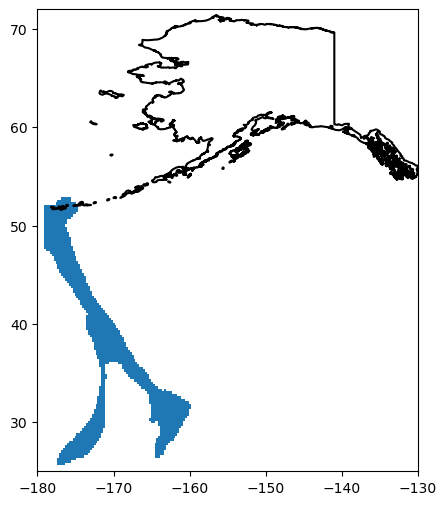

In [8]:
#plot a random datetime from the raw Alaska ARs
#these shapes represent landfalling ARs at individual 6hr timesteps...
#run this cell multiple times to get an idea of what some of these look like

random_date = random.choice(list(raw.index))
fig, ax = plt.subplots(figsize=(6,6))
#plt.suptitle)

ak_d.boundary.plot(ax=ax, color='black')
raw[raw.index==random_date].plot(ax=ax)

plt.xlim([-180, -130])
plt.ylim([25, 72])

In [9]:
#count number of landfalling AR events when grouped by adjacent dates
len(events)

1629

In [10]:
#average landfalling AR events per year ...  is this figure reasonable?
len(events)/30

54.3

In [11]:
#check attributes:
#event IDs are unique integers, could also be labeled using year / month / etc
#start and end columns can be parsed as datetime objects to get approximate duration
#multipolygons can be dissolved into single polygon representing entire AR impact area
#properties are disregarded during the grouping operation - could these values be aggregated somehow?

events.head()

,event_id,start,end,sumtot_str,sumrel_str,geometry
0,0,1992-01-01 06:00:00,1992-01-01 12:00:00,4464208,931,"MULTIPOLYGON (((-149.62500 61.12500, -149.3750..."
1,1,1992-01-08 00:00:00,1992-01-11 12:00:00,13563651,3010,"MULTIPOLYGON (((-145.62500 60.62500, -145.1250..."
2,2,1992-01-13 12:00:00,1992-01-19 00:00:00,26891085,4532,"MULTIPOLYGON (((-154.62500 60.62500, -154.1250..."
3,3,1992-01-25 06:00:00,1992-01-26 12:00:00,3045136,1060,"MULTIPOLYGON (((-156.12500 57.37500, -155.1250..."
4,4,1992-01-29 18:00:00,1992-01-30 12:00:00,15236696,2018,"MULTIPOLYGON (((-140.12500 56.62500, -137.8750..."


In [268]:
ak_ars = raw
ak_ars['dt'] = pd.to_datetime(raw['time'])

#limited subset containing a known multi-AR event
ak_ars = ak_ars[(ak_ars['dt'] > '2020-01-01') & (ak_ars['dt'] < '2020-03-01')].copy()

#below is function for ar_detection.py
ak_ars["diff"] = ak_ars["dt"].diff().dt.days.gt(1).cumsum()

dfs = []

for d in ak_ars["diff"].unique():
    sub = ak_ars[ak_ars["diff"] == d].copy()

    overlap_matrix = sub.geometry.apply(lambda x: sub.geometry.intersects(x)).values.astype(int)
    n, labels = connected_components(overlap_matrix)
    sub['group'] = labels
    sub['start'] = sub['dt']
    sub['end'] = sub['dt']
    sub["sumtot_str"] = sub["tot_str"]
    sub["sumrel_str"] = sub["rel_str"]
    sub['ratio_m'] = sub['ratio']
    sub['len_km_m'] = sub['length']
    sub['orient_m'] = sub['orient']
    sub['poleward_m'] = sub['poleward']
    sub['dircoher_m'] = sub['dir_coher']
    sub['mean_dir_m'] = sub['mean_dir']

    res = sub.dissolve(by='group', aggfunc={
         "start": "min",
         "end": "max",
         "sumtot_str": "sum",
         "sumrel_str": "sum",
         "ratio_m": "mean",
         "len_km_m": "mean",
         "orient_m": "mean",
         "poleward_m": "mean",
         "dircoher_m": "mean",
         "mean_dir_m": "mean"}
         )

    for i in res.index:
        #calculate duration from datetime columns
        #after subtracting, add 6hrs as minimum event length.... this assures a single timestep event is not zero duration!
        res.loc[i, 'dur_hrs'] = ((res['end'][i]-res['start'][i]).total_seconds()/3600) + 6

    #calculate total and relative intensity
    res['tintensity'] = res['sumtot_str']/res['dur_hrs']
    res['rintensity'] = res['sumrel_str']/res['dur_hrs']

    res = res.round({
        'ratio_m': 0, 
        'len_km_m': 0, 
        'orient_m': 0, 
        'poleward_m':0, 
        'dircoher_m':0, 
        'mean_dir_m':0, 
        'dur_hrs':0,
        'tintensity':0,
        'rintensity':0
        })

    dfs.append(res)

    events = pd.concat(dfs)
    events = events.reset_index(drop=True).rename(columns={'index': 'event_id'})
    #events.crs = ars.crs

    # reset datetime columns as strings for output (datetime fields not supported in ESRI shp files)
    events["start"] = events["start"].astype(str)
    events["end"] = events["end"].astype(str)

#     # export condensed event AR geodataframe to shp
#     events.to_file(fp_events, index=True)

In [275]:
events

RangeIndex(start=0, stop=10, step=1)